## ARIMA MODEL FOR AMZN STOCK PREDICTION

### Time Series Analysis

Any data that collectively represents how a system/process/behaviour changes over time is known as Time Series data. Time series forecasting uses information regarding historical values and associated patterns to predict future activity. In this project, we are going to predict tomorrow's closing price of Amazon Stock (AMZN) by analysing the stock data for over a time period(3 years) until today. Predicting the performance of stock market is one of the most difficult tasks as the share prices are highly volatile for various reasons. Thus, forecasting prices with high accuracy rates is is difficult. ARIMA is a very popular statistical method for time series forecasting. ARIMA models take into account the past values to predict the future values. 

### ARIMA

ARIMA (Auto-Regressive Integrated Moving Average) is a technique for modelling time series data for forecasting or predicting the future data points in the series by taking into consideration the following parameters:

1. Pattern or trend of growth/decline
2. Rate of change of growth/decline
3. Noise between consecutive data points

In [2]:
import sys
sys.path

Out[ 1 ]: 
['/local_disk0/tmp/1556255716231-0',
 '/local_disk0/spark-00188c9e-4d5b-4b11-9c9b-7b8e683450e7/userFiles-79497e09-9617-49ed-817e-6e91021dde15',
 '/databricks/spark/python',
 '/databricks/spark/python/lib/py4j-0.10.7-src.zip',
 '/databricks/jars/spark--driver--driver-spark_2.4_2.11_deploy.jar',
 '/local_disk0/pythonVirtualEnvDirs/virtualEnv-242f699e-acc8-4520-8407-c20e3d267906/lib/python35.zip',
 '/local_disk0/pythonVirtualEnvDirs/virtualEnv-242f699e-acc8-4520-8407-c20e3d267906/lib/python3.5',
 '/local_disk0/pythonVirtualEnvDirs/virtualEnv-242f699e-acc8-4520-8407-c20e3d267906/lib/python3.5/plat-x86_64-linux-gnu',
 '/local_disk0/pythonVirtualEnvDirs/virtualEnv-242f699e-acc8-4520-8407-c20e3d267906/lib/python3.5/lib-dynload',
 '/usr/lib/python3.5',
 '/usr/lib/python3.5/plat-x86_64-linux-gnu',
 '/local_disk0/pythonVirtualEnvDirs/virtualEnv-242f699e-acc8-4520-8407-c20e3d267906/lib/python3.5/site-packages',
 '/databricks/python/lib/python3.5/site-packages',
 '/usr/local/lib/python3.5/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/databricks/python/lib/python3.5/site-packages/IPython/extensions']

### Importing the necessary Libraries

In [4]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date
from datetime import datetime
import matplotlib.pyplot as plt
import fix_yahoo_finance as yf 
import pyspark as spark
from io import StringIO
import time, json
from datetime import date, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.metrics import *
from matplotlib import style
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import warnings
from prettytable import PrettyTable
rcParams['figure.figsize'] = 16,8
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list, struct
from pyspark.sql.types import FloatType, StructField, StructType, StringType, TimestampType
from sklearn.metrics import mean_squared_error

%matplotlib inline is not supported in Databricks.
You can display matplotlib figures using display(). For an example, see https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html

### Reading Data

Data is pulled from Yahoo Finance with start date as 1/1/2016 and end date as current date so as to take into consideration the most recent trend for better predictions.

In [6]:
spark = SparkSession.builder.getOrCreate()

In [7]:
# File location and type
file_location = "/FileStore/tables/FileStore/tables/amzn.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df)

Date,High,Low,Open,Close,Volume,Adj Close
2016-01-04,657.719970703125,627.510009765625,656.2899780273438,636.989990234375,9314500,636.989990234375
2016-01-05,646.9099731445312,627.6500244140625,646.8599853515625,633.7899780273438,5822600,633.7899780273438
2016-01-06,639.7899780273438,620.3099975585938,622.0,632.6500244140625,5329200,632.6500244140625
2016-01-07,630.0,605.2100219726562,621.7999877929688,607.9400024414062,7074900,607.9400024414062
2016-01-08,624.1400146484375,606.0,619.6599731445312,607.0499877929688,5512900,607.0499877929688
2016-01-11,619.8499755859375,598.5700073242188,612.47998046875,617.739990234375,4869200,617.739990234375
2016-01-12,625.989990234375,612.239990234375,625.25,617.8900146484375,4724100,617.8900146484375
2016-01-13,620.8800048828125,579.1599731445312,620.8800048828125,581.8099975585938,7655200,581.8099975585938
2016-01-14,602.25,569.8800048828125,580.25,593.0,7238000,593.0
2016-01-15,584.6199951171875,565.2999877929688,572.239990234375,570.1799926757812,7784500,570.1799926757812


In [8]:
df.describe()

Out[ 75 ]: DataFrame[summary: string, Date: string, High: string, Low: string, Open: string, Close: string, Volume: string, Adj Close: string]

In [9]:
df.head(5)

Out[ 76 ]: 
[Row(Date='2016-01-04', High='657.719970703125', Low='627.510009765625', Open='656.2899780273438', Close='636.989990234375', Volume='9314500', Adj Close='636.989990234375'),
 Row(Date='2016-01-05', High='646.9099731445312', Low='627.6500244140625', Open='646.8599853515625', Close='633.7899780273438', Volume='5822600', Adj Close='633.7899780273438'),
 Row(Date='2016-01-06', High='639.7899780273438', Low='620.3099975585938', Open='622.0', Close='632.6500244140625', Volume='5329200', Adj Close='632.6500244140625'),
 Row(Date='2016-01-07', High='630.0', Low='605.2100219726562', Open='621.7999877929688', Close='607.9400024414062', Volume='7074900', Adj Close='607.9400024414062'),
 Row(Date='2016-01-08', High='624.1400146484375', Low='606.0', Open='619.6599731445312', Close='607.0499877929688', Volume='5512900', Adj Close='607.0499877929688')]

### Feature Description

The data pulled from Yahoo Finance is stored in a .csv file. The AMZN stock data has the following features:

1. Date - in format: yyyy-mm-dd
2. High - Highest price reached in the day
3. Low	 - Lowest price reached in the day
4. Open - price of the stock at market open 
5. Close - price of the stock at market close
6. Volume - Number of shares traded
7. Adj Close - stock's closing price on any given day of trading that has been amended to include any distributions and corporate actions that occurred at any time before the next day's open

In [11]:
df = df.select(
        df['Date'].cast(StringType()),
        df['Close'].cast(FloatType())
    )

In [12]:
df.head(5)

Out[ 78 ]: 
[Row(Date='2016-01-04', Close=636.989990234375),
 Row(Date='2016-01-05', Close=633.7899780273438),
 Row(Date='2016-01-06', Close=632.6500244140625),
 Row(Date='2016-01-07', Close=607.9400024414062),
 Row(Date='2016-01-08', Close=607.0499877929688)]

In [13]:
df.select(df.Date, df.Close).show()

+----------+------+
 Date| Close|
+----------+------+
2016-01-04|636.99|
2016-01-05|633.79|
2016-01-06|632.65|
2016-01-07|607.94|
2016-01-08|607.05|
2016-01-11|617.74|
2016-01-12|617.89|
2016-01-13|581.81|
2016-01-14| 593.0|
2016-01-15|570.18|
2016-01-19|574.48|
2016-01-20|571.77|
2016-01-21|575.02|
2016-01-22|596.38|
2016-01-25|596.53|
2016-01-26|601.25|
2016-01-27|583.35|
2016-01-28|635.35|
2016-01-29| 587.0|
2016-02-01|574.81|
+----------+------+
only showing top 20 rows

In [14]:
df = df.toPandas()

In [15]:
df.describe()

Out[ 81 ]: 
 Close
count 829.000000
mean 1156.390137
std 436.620728
min 482.070007
25% 771.880005
50% 989.840027
75% 1598.010010
max 2039.510010

In [16]:
df.index =df['Date']

In [17]:
df.head()

Out[ 83 ]: 
 Date Close
Date 
2016-01-04 2016-01-04 636.989990
2016-01-05 2016-01-05 633.789978
2016-01-06 2016-01-06 632.650024
2016-01-07 2016-01-07 607.940002
2016-01-08 2016-01-08 607.049988

In [18]:
df['Date'] = pd.to_datetime(df['Date'])

indexed_df = df.set_index('Date')

In [19]:
ts = indexed_df['Close']
ts.head()

Out[ 85 ]: 
Date
2016-01-04 636.989990
2016-01-05 633.789978
2016-01-06 632.650024
2016-01-07 607.940002
2016-01-08 607.049988
Name: Close, dtype: float32

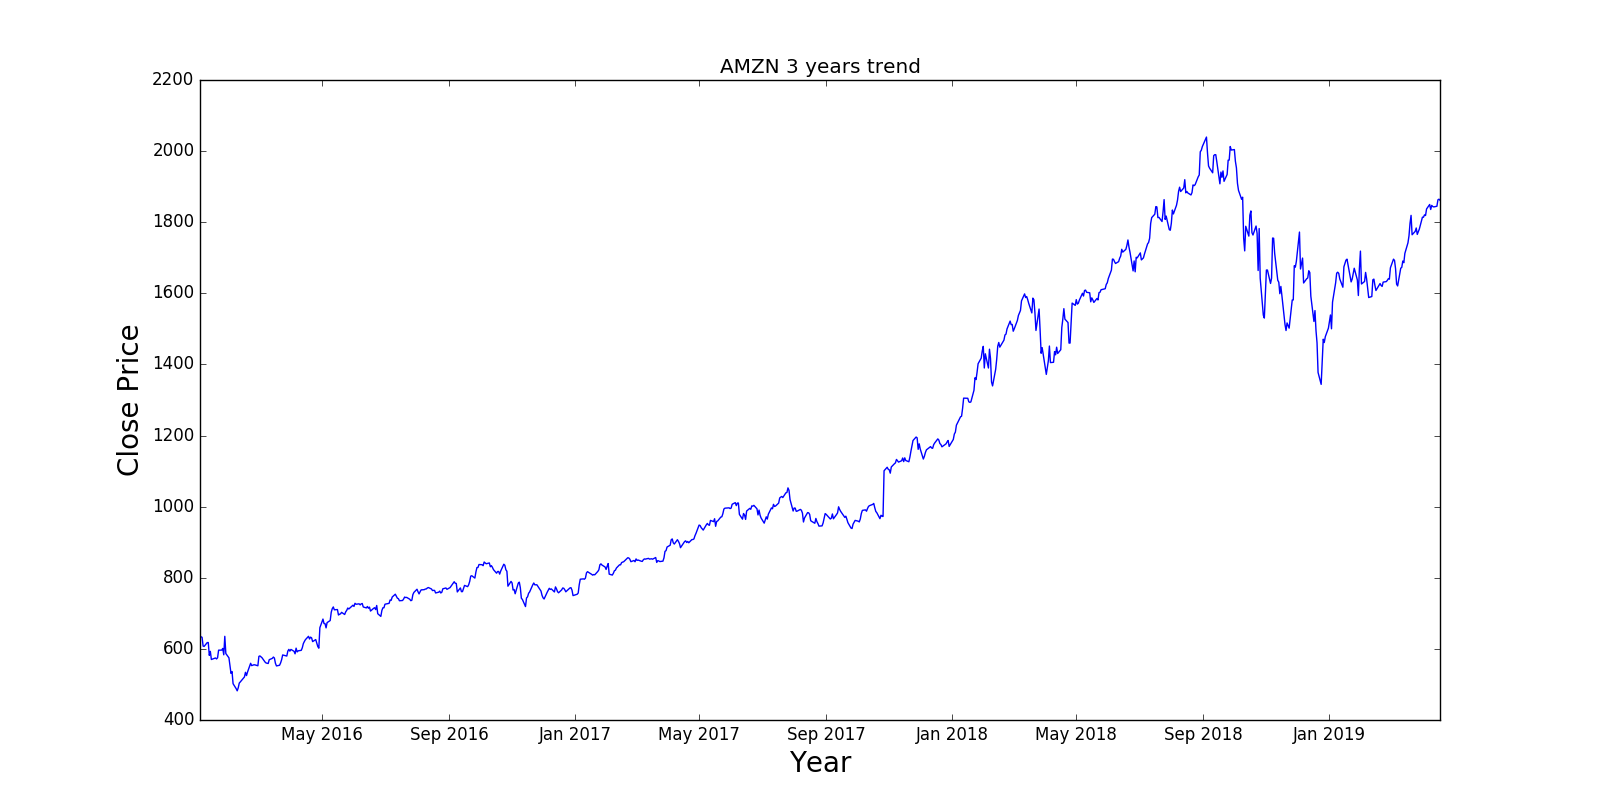

In [20]:
# visualize the time series to see how AMZN stock Close price trends over time
plt.figure(figsize=(16,8))
plt.plot(ts)
plt.title('AMZN 3 years trend')
plt.xlabel('Year',fontsize=20)
plt.ylabel('Close Price',fontsize=20)
display()

In [21]:
# resampling

ts = ts.resample('D').mean()
ts

Out[ 87 ]: 
Date
2016-01-04 636.989990
2016-01-05 633.789978
2016-01-06 632.650024
2016-01-07 607.940002
2016-01-08 607.049988
2016-01-09 NaN
2016-01-10 NaN
2016-01-11 617.739990
2016-01-12 617.890015
2016-01-13 581.809998
2016-01-14 593.000000
2016-01-15 570.179993
2016-01-16 NaN
2016-01-17 NaN
2016-01-18 NaN
2016-01-19 574.479980
2016-01-20 571.770020
2016-01-21 575.020020
2016-01-22 596.380005
2016-01-23 NaN
2016-01-24 NaN
2016-01-25 596.530029
2016-01-26 601.250000
2016-01-27 583.349976
2016-01-28 635.349976
2016-01-29 587.000000
2016-01-30 NaN
2016-01-31 NaN
2016-02-01 574.809998
2016-02-02 552.099976
 ... 
2019-03-20 1797.270020
2019-03-21 1819.260010
2019-03-22 1764.770020
2019-03-23 NaN
2019-03-24 NaN
2019-03-25 1774.260010
2019-03-26 1783.760010
2019-03-27 1765.699951
2019-03-28 1773.420044
2019-03-29 1780.750000
2019-03-30 NaN
2019-03-31 NaN
2019-04-01 1814.189941
2019-04-02 1813.979980
2019-04-03 1820.699951
2019-04-04 1818.859985
2019-04-05 1837.280029
2019-04-06 NaN
2019-04-07 NaN
2019-04-08 1849.859985
2019-04-09 1835.839966
2019-04-10 1847.329956
2019-04-11 1844.069946
2019-04-12 1843.060059
2019-04-13 NaN
2019-04-14 NaN
2019-04-15 1844.869995
2019-04-16 1863.040039
2019-04-17 1864.819946
2019-04-18 1861.689941
Freq: D, Name: Close, dtype: float32

In [22]:
ts = ts.dropna()

In [23]:
ts

Out[ 89 ]: 
Date
2016-01-04 636.989990
2016-01-05 633.789978
2016-01-06 632.650024
2016-01-07 607.940002
2016-01-08 607.049988
2016-01-11 617.739990
2016-01-12 617.890015
2016-01-13 581.809998
2016-01-14 593.000000
2016-01-15 570.179993
2016-01-19 574.479980
2016-01-20 571.770020
2016-01-21 575.020020
2016-01-22 596.380005
2016-01-25 596.530029
2016-01-26 601.250000
2016-01-27 583.349976
2016-01-28 635.349976
2016-01-29 587.000000
2016-02-01 574.809998
2016-02-02 552.099976
2016-02-03 531.070007
2016-02-04 536.260010
2016-02-05 502.130005
2016-02-08 488.100006
2016-02-09 482.070007
2016-02-10 490.480011
2016-02-11 503.820007
2016-02-12 507.079987
2016-02-16 521.099976
 ... 
2019-03-08 1620.800049
2019-03-11 1670.619995
2019-03-12 1673.099976
2019-03-13 1690.810059
2019-03-14 1686.219971
2019-03-15 1712.359985
2019-03-18 1742.150024
2019-03-19 1761.849976
2019-03-20 1797.270020
2019-03-21 1819.260010
2019-03-22 1764.770020
2019-03-25 1774.260010
2019-03-26 1783.760010
2019-03-27 1765.699951
2019-03-28 1773.420044
2019-03-29 1780.750000
2019-04-01 1814.189941
2019-04-02 1813.979980
2019-04-03 1820.699951
2019-04-04 1818.859985
2019-04-05 1837.280029
2019-04-08 1849.859985
2019-04-09 1835.839966
2019-04-10 1847.329956
2019-04-11 1844.069946
2019-04-12 1843.060059
2019-04-15 1844.869995
2019-04-16 1863.040039
2019-04-17 1864.819946
2019-04-18 1861.689941
Name: Close, dtype: float32

### Check for Stationarity of the Time series

Stationary Time Series data does not have any upward or downward trend or seasonal effects. Mean or variance are consistent over time

Non-Stationary Time Series data show trends, seasonal effects, and other structures depend on time. Forecasting performance is dependent on the time of observation. Mean and variance change over time and a drift in the model is captured.

We are using a statistical method called Dickey-Fuller test to check if our time series is stationary or not.

In [25]:
# check for stationarity

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    orig = plt.plot(timeseries, color='green',label='AMZN Data')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('Time(Days)',fontsize=15)
    plt.ylabel('$(Dollar)',fontsize=15)
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [26]:
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic -0.398377
p-value 0.910369
#Lags Used 18.000000
Number of Observations Used 810.000000
Critical Value (10%) -2.568674
Critical Value (5%) -2.865115
Critical Value (1%) -3.438449
dtype: float64

#### Because the test statistic is more than the 5% critical value and the p-value is larger than 0.05, the moving average is not constant over time and the null hypothesis of the Dickey-Fuller test cannot be rejected. This shows that the weekly time series is not stationary. Before you can apply ARIMA models for forecasting, you need to transform this time series into a stationary time series.

In [28]:
# apply a non linear log transform

ts_log = np.log(ts)

In [29]:
test_stationarity(ts_log)

Results of Dickey-Fuller Test:
Test Statistic -0.619399
p-value 0.866538
#Lags Used 0.000000
Number of Observations Used 828.000000
Critical Value (10%) -2.568632
Critical Value (5%) -2.865037
Critical Value (1%) -3.438272
dtype: float64

#### The Dickey-Fuller test results confirm that the series is still non-stationary. Again the test statistic is larger than the 5% critical value and the p-value larger than 0.05

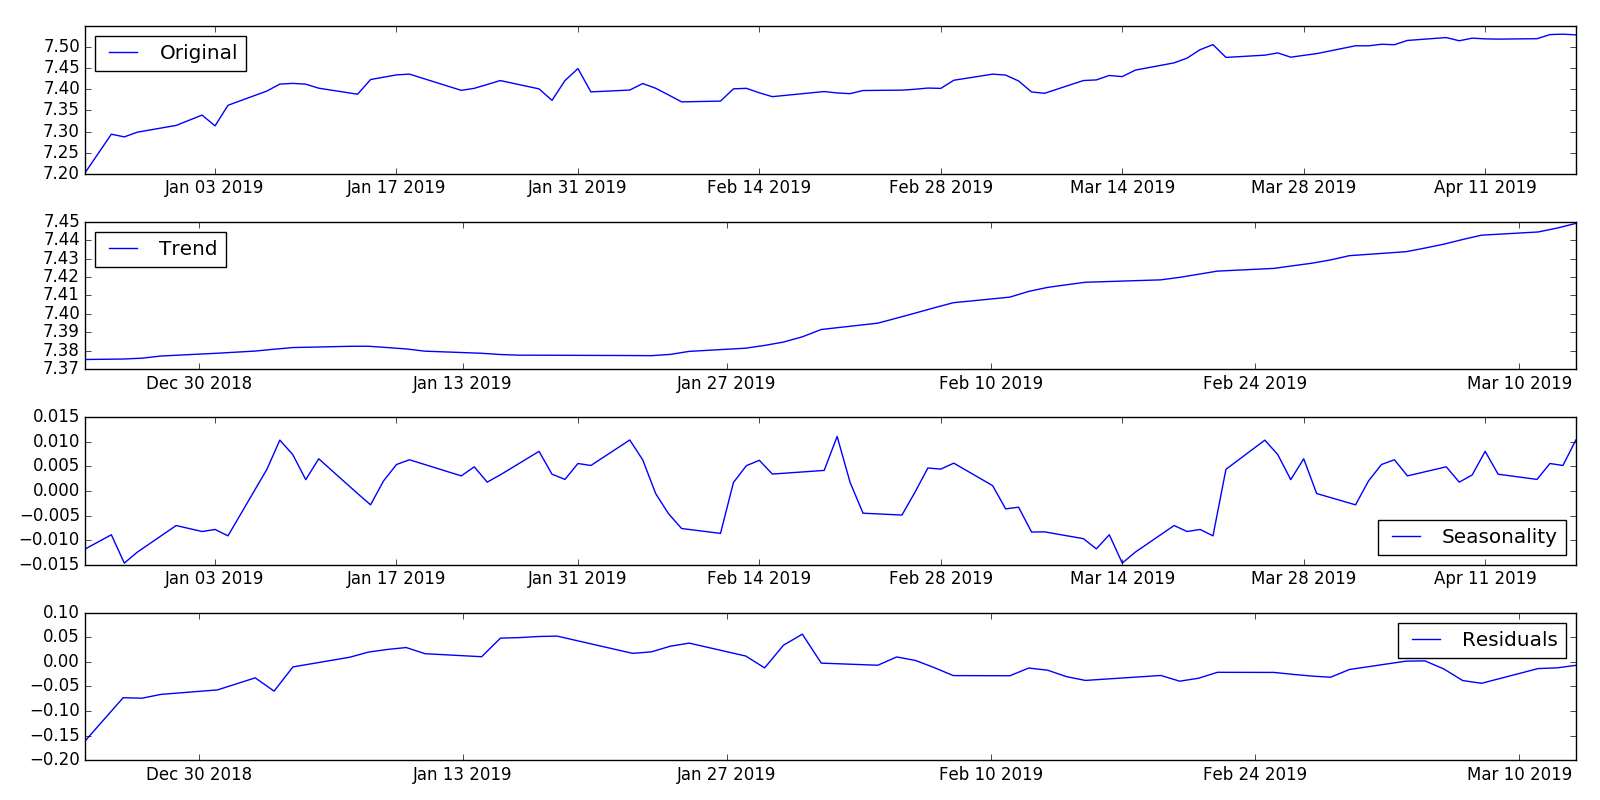

In [31]:
# remove trend and seasonality with decomposition

decomposition = seasonal_decompose(ts_log, freq = 52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,8))
plt.subplot(411)
plt.plot(ts_log[-80:], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend[-80:], label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal[-80:],label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual[-80:], label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
display()

#### Time series are stationary if they do not have trend or seasonal effects. We are going to use the difference transform to remove the time series' dependence on time.

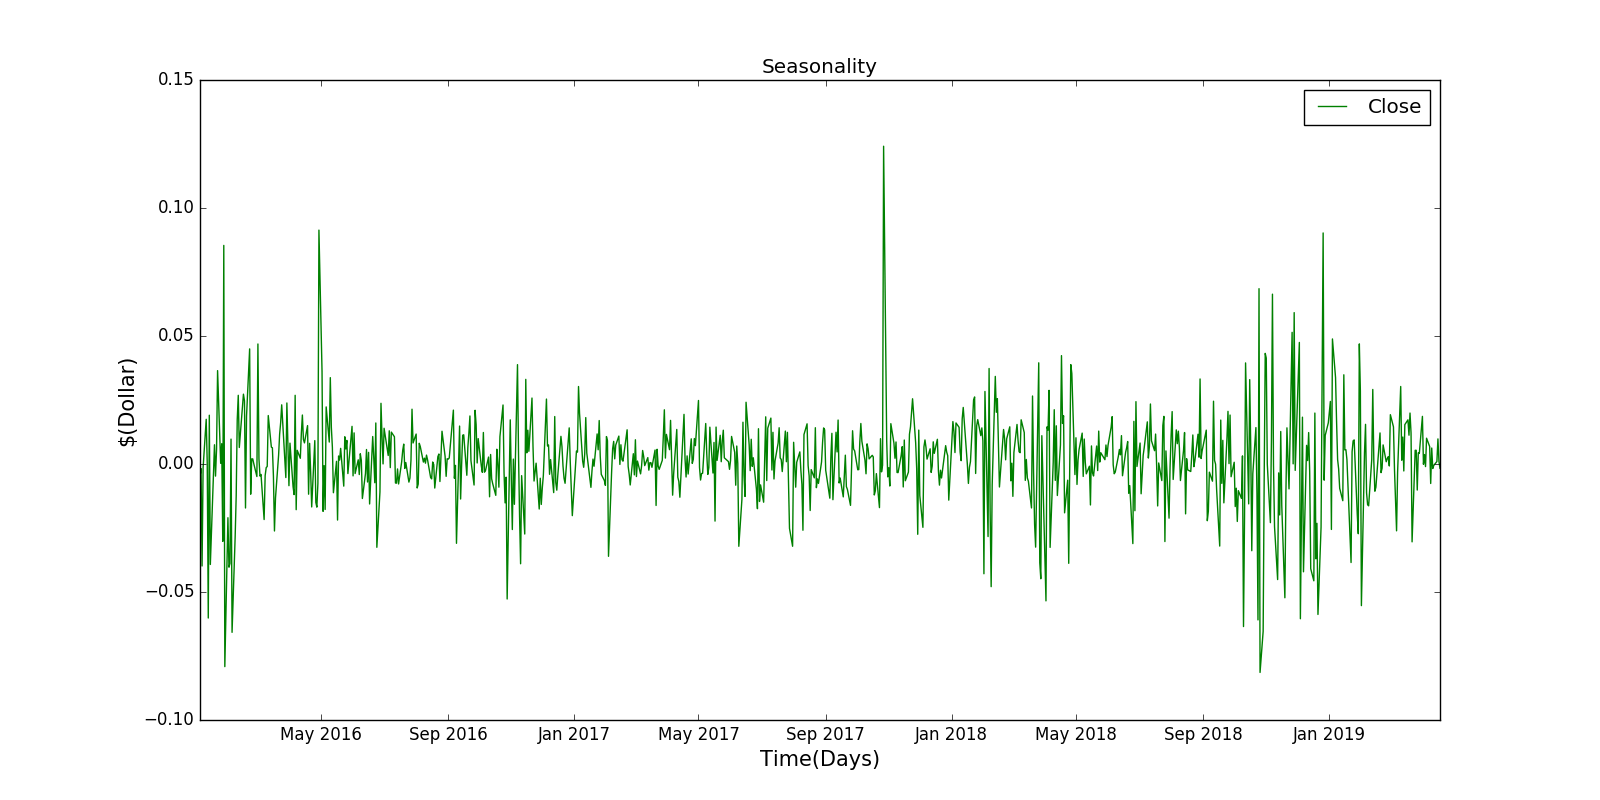

In [33]:
# remove trend and seasonality with differencing
ts_log_diff = ts_log - ts_log.shift()
plt.figure(figsize=(16,8))
plt.plot(ts_log_diff,color='green')
plt.legend(loc='best')
plt.xlabel('Time(Days)',fontsize=15)
plt.ylabel('$(Dollar)',fontsize=15)
plt.title('Seasonality')
display()

In [34]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

Results of Dickey-Fuller Test:
Test Statistic -1.195377e+01
p-value 4.256576e-22
#Lags Used 7.000000e+00
Number of Observations Used 8.200000e+02
Critical Value (10%) -2.568650e+00
Critical Value (5%) -2.865071e+00
Critical Value (1%) -3.438350e+00
dtype: float64

#### The above graph shows how the rolling mean and rolling standard deviation are comparitively consistent over time after the time series transformation. We can proceed to use this transformed data for training our ARIMA model and forecasting the upcoming week's stock price.

### ARIMA Model

In [36]:
size = int(len(ts_log)*(0.7))
train, test = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,1)) #The order(p,d,q) of the model
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()[0]
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

    
error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


predicted=1520.311461, expected=1460.090088
predicted=1462.891021, expected=1460.170166
predicted=1462.287973, expected=1517.959595
predicted=1519.538678, expected=1572.620239
predicted=1574.817177, expected=1566.129883
predicted=1568.592921, expected=1582.260132
predicted=1584.641879, expected=1569.680420
predicted=1572.193377, expected=1572.079590
predicted=1574.501779, expected=1580.950195
predicted=1583.354863, expected=1600.139771
predicted=1602.540484, expected=1592.390381
predicted=1594.931431, expected=1608.000366
predicted=1610.432222, expected=1609.080322
predicted=1611.610441, expected=1602.910278
predicted=1605.466281, expected=1601.539673
predicted=1604.054157, expected=1576.119995
predicted=1578.702340, expected=1587.280151
predicted=1589.652915, expected=1581.760010
predicted=1584.228705, expected=1574.369873
predicted=1576.823332, expected=1585.460083
predicted=1587.812894, expected=1581.400269
predicted=1583.846053, expected=1601.859741
predicted=1604.181173, expected=1603.070068
predicted=1605.538275, expected=1610.150269
predicted=1612.592941, expected=1612.869751
predicted=1615.350416, expected=1624.890381
predicted=1627.333945, expected=1629.619751
predicted=1632.130350, expected=1641.539673
predicted=1644.030224, expected=1665.270264
predicted=1667.751480, expected=1696.349731
predicted=1698.910517, expected=1695.749634
predicted=1698.492977, expected=1689.300415
predicted=1692.054538, expected=1683.989990
predicted=1686.714490, expected=1689.119995
predicted=1691.795206, expected=1698.749756
predicted=1701.424849, expected=1704.860229
predicted=1707.571550, expected=1723.859619
predicted=1726.554396, expected=1715.970093
predicted=1718.792399, expected=1723.789795
predicted=1726.538159, expected=1734.779907
predicted=1737.539843, expected=1750.079956
predicted=1752.861195, expected=1730.219727
predicted=1733.150626, expected=1715.669922
predicted=1718.503625, expected=1663.149902
predicted=1665.917548, expected=1691.089600
predicted=1693.572617, expected=1660.510376
predicted=1663.326284, expected=1701.450073
predicted=1703.710460, expected=1699.799927
predicted=1702.505905, expected=1713.780273
predicted=1716.358097, expected=1693.960327
predicted=1696.854032, expected=1699.730225
predicted=1702.346796, expected=1710.629639
predicted=1713.213275, expected=1739.020386
predicted=1741.493971, expected=1743.070068
predicted=1745.826825, expected=1755.000488
predicted=1757.705870, expected=1796.619873
predicted=1799.143580, expected=1813.029907
predicted=1815.881564, expected=1822.489868
predicted=1825.437910, expected=1843.929688
predicted=1846.833766, expected=1842.919678
predicted=1846.022671, expected=1812.970215
predicted=1816.233721, expected=1813.699951
predicted=1816.685899, expected=1802.000244
predicted=1805.051594, expected=1829.239868
predicted=1832.012674, expected=1863.609741
predicted=1866.457059, expected=1808.000122
predicted=1811.575235, expected=1817.270142
predicted=1820.154677, expected=1779.219604
predicted=1782.539636, expected=1777.439697
predicted=1780.316913, expected=1797.170044
predicted=1799.841824, expected=1834.329590
predicted=1836.934183, expected=1823.290405
predicted=1826.398261, expected=1847.749634
predicted=1850.507484, expected=1862.479736
predicted=1865.400474, expected=1886.519775
predicted=1889.411791, expected=1898.520264
predicted=1901.586864, expected=1886.300293
predicted=1889.597632, expected=1896.199585
predicted=1899.274713, expected=1919.650391
predicted=1922.640027, expected=1882.619751
predicted=1886.214777, expected=1886.519775
predicted=1889.622222, expected=1882.220337
predicted=1885.401038, expected=1876.709595
predicted=1879.883547, expected=1883.419800
predicted=1886.457914, expected=1904.899658
predicted=1907.815048, expected=1902.899658
predicted=1906.095557, expected=1905.390137
predicted=1908.536521, expected=1927.680176
predicted=1930.641622, expected=1932.819824
predicted=1936.007166, expected=1998.1004

In [37]:
predictions_series = pd.Series(predictions, index = test.index)

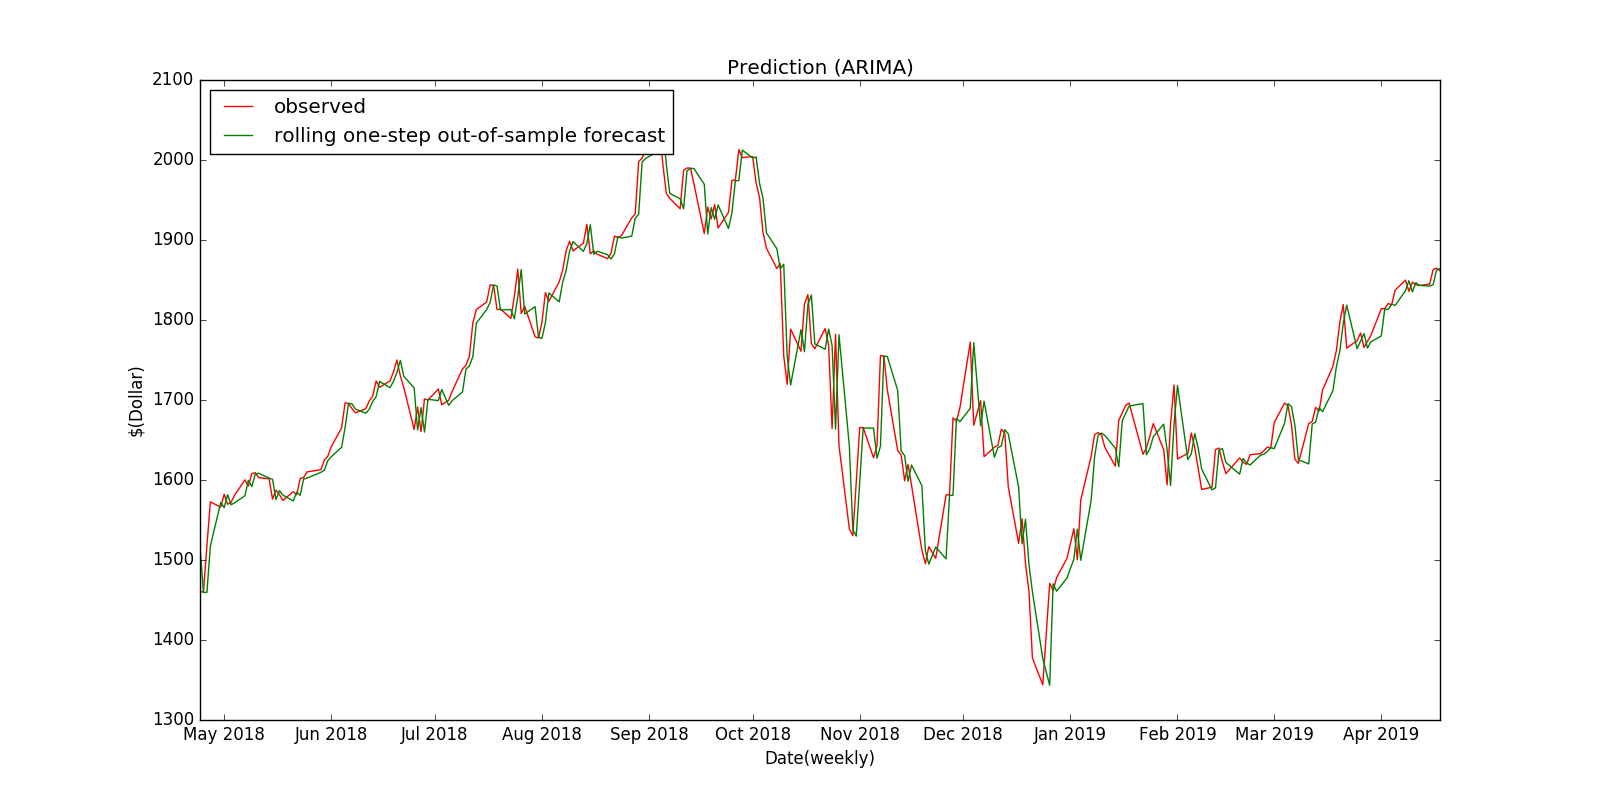

In [38]:
plt.figure(figsize=(16,8))
fig, ax = plt.subplots()
ax.set(title='Prediction (ARIMA)', xlabel='Date(weekly)', ylabel='$(Dollar)')
ax.plot((np.exp(test)), label='observed', color='r')
ax.plot(np.exp(predictions_series), color='g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
display()

In [39]:
r2

Out[ 99 ]: 0.92477717722438024

#### The above model was run with values of parameters (p,d,q) set randomly as (0,1,1). The model performs with an accuracy of 91.7%. We need to tune the parameters to get the best combination of (p,d,q) to see if the model performs better.

### Tuning hyper parameters for our ARIMA model

We are implementing grid search to find the best combination of p, d, q values for our model

In [42]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

order=(2,1,1)
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        # model_fit = model.fit(disp=0)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, (order))
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    #print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(ts_log, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=3.655
ARIMA(0, 1, 1) RMSE=0.021
ARIMA(0, 1, 2) RMSE=0.021
ARIMA(0, 1, 3) RMSE=0.021
ARIMA(0, 1, 4) RMSE=0.021
ARIMA(0, 2, 1) RMSE=0.021
ARIMA(1, 0, 0) RMSE=0.021
ARIMA(1, 1, 0) RMSE=0.021
ARIMA(1, 2, 0) RMSE=0.026
ARIMA(1, 2, 1) RMSE=0.021
ARIMA(1, 2, 2) RMSE=0.021
ARIMA(2, 1, 0) RMSE=0.021
ARIMA(2, 1, 1) RMSE=0.021
ARIMA(2, 2, 0) RMSE=0.024
ARIMA(2, 2, 1) RMSE=0.021
ARIMA(3, 1, 0) RMSE=0.021
ARIMA(3, 2, 0) RMSE=0.024
ARIMA(3, 2, 1) RMSE=0.021
ARIMA(4, 1, 0) RMSE=0.021
ARIMA(4, 1, 1) RMSE=0.021
ARIMA(4, 2, 0) RMSE=0.023
ARIMA(4, 2, 1) RMSE=0.021
ARIMA(4, 2, 2) RMSE=0.021

#### The combination of p,d,q values for which the RMSE is lowest is chosen as the best combination. In our case, there are multiple combinations with least RMSE of 0.021 and we will be comparing the accuracy of the corresponding model, to find the best one.

#### 1. Order = (0,2,1)

In [44]:
size = int(len(ts_log)*(0.7))
train, test = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(0,2,1)) #The order(p,d,q) of the model
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()[0]
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

    
error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


predicted=1521.924398, expected=1460.090088
predicted=1463.664255, expected=1460.170166
predicted=1463.628918, expected=1517.959595
predicted=1521.843544, expected=1572.620239
predicted=1577.014911, expected=1566.129883
predicted=1570.541169, expected=1582.260132
predicted=1586.768006, expected=1569.680420
predicted=1574.091789, expected=1572.079590
predicted=1576.462828, expected=1580.950195
predicted=1585.387203, expected=1600.139771
predicted=1604.719784, expected=1592.390381
predicted=1596.917735, expected=1608.000366
predicted=1612.613932, expected=1609.080322
predicted=1613.704738, expected=1602.910278
predicted=1607.462780, expected=1601.539673
predicted=1606.049798, expected=1576.119995
predicted=1580.403819, expected=1587.280151
predicted=1591.584967, expected=1581.760010
predicted=1586.018837, expected=1574.369873
predicted=1578.540416, expected=1585.460083
predicted=1589.681150, expected=1581.400269
predicted=1585.586664, expected=1601.859741
predicted=1606.174436, expected=1603.070068
predicted=1607.407365, expected=1610.150269
predicted=1614.522513, expected=1612.869751
predicted=1617.250711, expected=1624.890381
predicted=1629.344120, expected=1629.619751
predicted=1634.106352, expected=1641.539673
predicted=1646.107852, expected=1665.270264
predicted=1670.017130, expected=1696.349731
predicted=1701.353983, expected=1695.749634
predicted=1700.775817, expected=1689.300415
predicted=1694.247105, expected=1683.989990
predicted=1688.859623, expected=1689.119995
predicted=1693.996650, expected=1698.749756
predicted=1703.686598, expected=1704.860229
predicted=1709.834312, expected=1723.859619
predicted=1728.967851, expected=1715.970093
predicted=1721.020793, expected=1723.789795
predicted=1728.864128, expected=1734.779907
predicted=1739.930328, expected=1750.079956
predicted=1755.340677, expected=1730.219727
predicted=1735.323227, expected=1715.669922
predicted=1720.601261, expected=1663.149902
predicted=1667.633878, expected=1691.089600
predicted=1695.679053, expected=1660.510376
predicted=1664.890926, expected=1701.450073
predicted=1706.064088, expected=1699.799927
predicted=1704.448187, expected=1713.780273
predicted=1718.514273, expected=1693.960327
predicted=1698.535564, expected=1699.730225
predicted=1704.295056, expected=1710.629639
predicted=1715.263471, expected=1739.020386
predicted=1743.862767, expected=1743.070068
predicted=1747.961585, expected=1755.000488
predicted=1759.965310, expected=1796.619873
predicted=1801.897122, expected=1813.029907
predicted=1818.475416, expected=1822.489868
predicted=1828.007290, expected=1843.929688
predicted=1849.601075, expected=1842.919678
predicted=1848.588303, expected=1812.970215
predicted=1818.379472, expected=1813.699951
predicted=1819.041203, expected=1802.000244
predicted=1807.227410, expected=1829.239868
predicted=1834.633015, expected=1863.609741
predicted=1869.283279, expected=1808.000122
predicted=1813.270692, expected=1817.270142
predicted=1822.501450, expected=1779.219604
predicted=1784.153014, expected=1777.439697
predicted=1782.286745, expected=1797.170044
predicted=1802.131318, expected=1834.329590
predicted=1839.577972, expected=1823.290405
predicted=1828.482003, expected=1847.749634
predicted=1853.083011, expected=1862.479736
predicted=1867.937684, expected=1886.519775
predicted=1892.152726, expected=1898.520264
predicted=1904.256412, expected=1886.300293
predicted=1891.934087, expected=1896.199585
predicted=1901.863888, expected=1919.650391
predicted=1925.481271, expected=1882.619751
predicted=1888.184012, expected=1886.519775
predicted=1892.026312, expected=1882.220337
predicted=1887.673278, expected=1876.709595
predicted=1882.091672, expected=1883.419800
predicted=1888.815198, expected=1904.899658
predicted=1910.442077, expected=1902.899658
predicted=1908.433031, expected=1905.390137
predicted=1910.911096, expected=1927.680176
predicted=1933.345275, expected=1932.819824
predicted=1938.528652, expected=1998.1004

In [45]:
predictions_series = pd.Series(predictions, index = test.index)

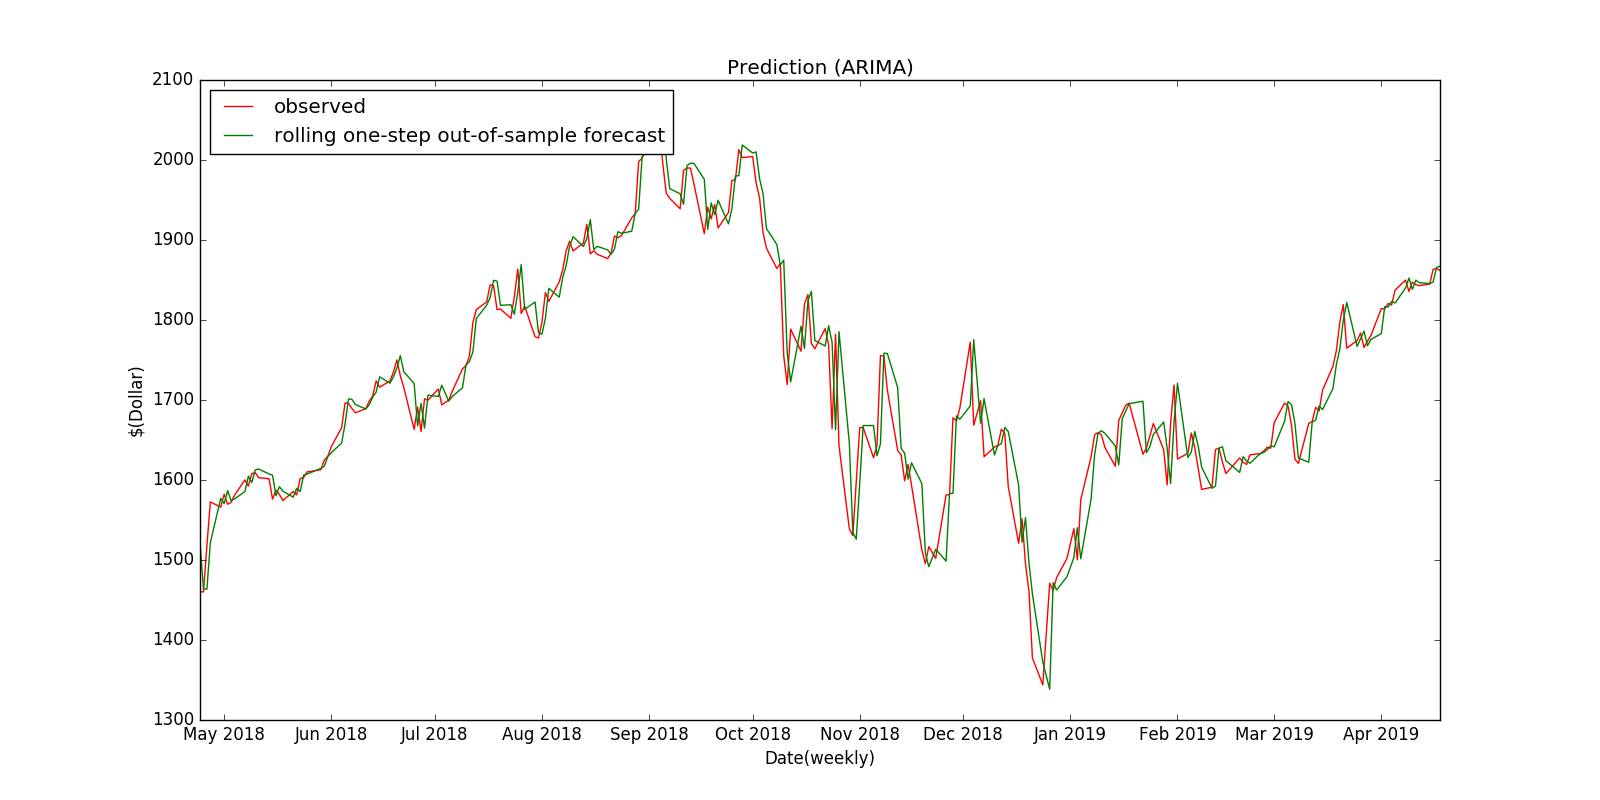

In [46]:
plt.figure(figsize=(16,8))
fig, ax = plt.subplots()
ax.set(title='Prediction (ARIMA)', xlabel='Date(weekly)', ylabel='$(Dollar)')
ax.plot((np.exp(test)), label='observed', color='r')
ax.plot(np.exp(predictions_series), color='g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
display()

In [47]:
r2

Out[ 59 ]: 0.92370365449340641

#### Accuracy for Order = (0,2,1) is 91.7%

#### 2. Order = (1,0,0)

In [49]:
size = int(len(ts_log)*(0.7))
train, test = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,0)) #The order(p,d,q) of the model
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()[0]
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

    
error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


predicted=1517.233452, expected=1460.090088
predicted=1459.453556, expected=1460.170166
predicted=1459.535438, expected=1517.959595
predicted=1517.323686, expected=1572.620239
predicted=1571.985262, expected=1566.129883
predicted=1565.495971, expected=1582.260132
predicted=1581.629035, expected=1569.680420
predicted=1569.049561, expected=1572.079590
predicted=1571.450708, expected=1580.950195
predicted=1580.323678, expected=1600.139771
predicted=1599.515918, expected=1592.390381
predicted=1591.767450, expected=1608.000366
predicted=1607.380089, expected=1609.080322
predicted=1608.461786, expected=1602.910278
predicted=1602.292853, expected=1601.539673
predicted=1600.923714, expected=1576.119995
predicted=1575.502632, expected=1587.280151
predicted=1586.664896, expected=1581.760010
predicted=1581.146001, expected=1574.369873
predicted=1573.756920, expected=1585.460083
predicted=1584.849274, expected=1581.400269
predicted=1580.790729, expected=1601.859741
predicted=1601.252317, expected=1603.070068
predicted=1602.464350, expected=1610.150269
predicted=1609.546465, expected=1612.869751
predicted=1612.267653, expected=1624.890381
predicted=1624.290314, expected=1629.619751
predicted=1629.021411, expected=1641.539673
predicted=1640.943440, expected=1665.270264
predicted=1665.274484, expected=1696.349731
predicted=1695.757322, expected=1695.749634
predicted=1695.158666, expected=1689.300415
predicted=1688.710537, expected=1683.989990
predicted=1683.401123, expected=1689.119995
predicted=1688.532948, expected=1698.749756
predicted=1698.164477, expected=1704.860229
predicted=1704.276651, expected=1723.859619
predicted=1723.277966, expected=1715.970093
predicted=1715.389361, expected=1723.789795
predicted=1723.210733, expected=1734.779907
predicted=1734.202534, expected=1750.079956
predicted=1749.504404, expected=1730.219727
predicted=1729.644074, expected=1715.669922
predicted=1715.094769, expected=1663.149902
predicted=1662.570224, expected=1691.089600
predicted=1690.511104, expected=1660.510376
predicted=1659.930871, expected=1701.450073
predicted=1700.870781, expected=1699.799927
predicted=1699.221916, expected=1713.780273
predicted=1713.203854, expected=1693.960327
predicted=1693.384137, expected=1699.730225
predicted=1699.155422, expected=1710.629639
predicted=1710.056411, expected=1739.020386
predicted=1738.448205, expected=1743.070068
predicted=1742.499303, expected=1755.000488
predicted=1754.431156, expected=1796.619873
predicted=1796.050882, expected=1813.029907
predicted=1813.033241, expected=1822.489868
predicted=1821.923675, expected=1843.929688
predicted=1843.934224, expected=1842.919678
predicted=1842.356098, expected=1812.970215
predicted=1812.406111, expected=1813.699951
predicted=1813.137196, expected=1802.000244
predicted=1801.438321, expected=1829.239868
predicted=1829.239885, expected=1863.609741
predicted=1863.049216, expected=1808.000122
predicted=1807.436308, expected=1817.270142
predicted=1816.707590, expected=1779.219604
predicted=1778.656027, expected=1777.439697
predicted=1776.877387, expected=1797.170044
predicted=1796.608707, expected=1834.329590
predicted=1833.768364, expected=1823.290405
predicted=1822.730136, expected=1847.749634
predicted=1847.190172, expected=1862.479736
predicted=1861.921394, expected=1886.519775
predicted=1885.962418, expected=1898.520264
predicted=1897.963909, expected=1886.300293
predicted=1885.745025, expected=1896.199585
predicted=1895.645430, expected=1919.650391
predicted=1919.097065, expected=1882.619751
predicted=1882.065919, expected=1886.519775
predicted=1885.967197, expected=1882.220337
predicted=1881.668802, expected=1876.709595
predicted=1876.159260, expected=1883.419800
predicted=1882.870557, expected=1904.899658
predicted=1904.351095, expected=1902.899658
predicted=1902.352276, expected=1905.390137
predicted=1904.843977, expected=1927.680176
predicted=1927.134708, expected=1932.819824
predicted=1932.275423, expected=1998.1004

In [50]:
predictions_series = pd.Series(predictions, index = test.index)

In [51]:
plt.figure(figsize=(16,8))
fig, ax = plt.subplots()
ax.set(title='Prediction (ARIMA)', xlabel='Date(weekly)', ylabel='$(Dollar)')
ax.plot((np.exp(test)), label='observed', color='r')
ax.plot(np.exp(predictions_series), color='g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

In [52]:
r2

Out[ 63 ]: 0.92501969912891169

#### Accuracy for Order = (1,0,0) = 91.8%

### Observations

The above graph represents the comparison of our observed stock close prices vs forecasted close price for the upcoming week with an accuracy of 91.8%

In [55]:
from prettytable import PrettyTable

In [56]:
result_hyperparam = PrettyTable()

result_hyperparam.field_names = ["Model(ARIMA(p,d,q))", "Accuracy"]

result_hyperparam.add_row(['ARIMA(0,1,1)',91.7])
result_hyperparam.add_row(['ARIMA(0,2,1)',91.7])
result_hyperparam.add_row(['ARIMA(1,0,0)',91.80])


print(result_hyperparam)

+---------------------+----------+
 Model(ARIMA(p,d,q)) | Accuracy |
+---------------------+----------+
 ARIMA(0,1,1) | 91.7 |
 ARIMA(0,2,1) | 91.7 |
 ARIMA(1,0,0) | 91.8 |
+---------------------+----------+

In [57]:
result_predictedvsexpected = PrettyTable()

result_predictedvsexpected.field_names = ["date", "predicted","expected"]

result_predictedvsexpected.add_row(['2019-04-21',1843.78,1857.53])
result_predictedvsexpected.add_row(['2019-04-14',1847.59,1844.03])
result_predictedvsexpected.add_row(['2019-04-07',1766.52,1821.01])
result_predictedvsexpected.add_row(['2019-03-31',1799.97,1775.57])
result_predictedvsexpected.add_row(['2019-03-24',1699.47,1777.06])

print(result_predictedvsexpected)

+------------+-----------+----------+
 date | predicted | expected |
+------------+-----------+----------+
 2019-04-21 | 1843.78 | 1857.53 |
 2019-04-14 | 1847.59 | 1844.03 |
 2019-04-07 | 1766.52 | 1821.01 |
 2019-03-31 | 1799.97 | 1775.57 |
 2019-03-24 | 1699.47 | 1777.06 |
+------------+-----------+----------+

### Conclusion

Predicting stock market prices is really a difficult task, as the market keeps changing continuously with time following a trend based on various factors. 
All Stock market data are a time series problem and we have analysed and transformed our Amazon stock price data treating its seasonality and trend as these affect the prediction.
We have modelled a ML algorithm called ARIMA(Auto-Regressive Integrated Moving Average) to forecast the stock market prices and tuned the hyper parameters to get a model that predicts with better accuracy.